In [305]:
import os
import math
import requests
import datetime
from datetime import date, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected = True)
cf.go_offline()

import psycopg2
connect = "user='rh1' password='Anal1st-R0undH0use' host='rds-rh1.4dapt.com' dbname='rh1'"
conn = psycopg2.connect(connect)
cursor = conn.cursor()

In [2]:
# Function adding independent Month, Day, Hour, Minute, Day of week columns from the date/time index to the dataframe

def timeValues(*arg):
    
    days = {
    0:"Monday",
    1:"Tuesday",
    2:"Wednesday",
    3:"Thursday",
    4:"Friday",
    5:"Saturday",
    6:"Sunday"
}
    
    for x in list(arg):
        x["Month"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.month))
        
        x["Day"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.day))
        
        x["Hour"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.hour))
        
        x["Minute"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.minute))
        
        x["Day of Week"] = list(x.reset_index()["Date/Time"].apply(lambda x: days[x.dayofweek]))

In [3]:
# Converting data types to floats

def convert(num):
    try:
        return(float(num))
    except:
        return(np.nan)

### Question 3

In [4]:
cursor.execute("SELECT * FROM siboniweather WHERE station_id = 'KCASANFR646' OR station_id = 'KCASANFR957'")
weatherData = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time", "Month", "Day", "Hour", "Minute", "Day of Week",
                                                 "Station ID", "School Day", "School Hour", "Lat", "Long", "Neighborhood",
                                                 "Temp", "RH%", "Rain Rate", "Solar Rad"])

weatherData["Temp"] = weatherData["Temp"].apply(lambda x: convert(x))
weatherData["RH%"] = weatherData["RH%"].apply(lambda x: convert(x))
weatherData["Rain Rate"] = weatherData["Rain Rate"].apply(lambda x: convert(x))
weatherData["Solar Rad"] = weatherData["Solar Rad"].apply(lambda x: convert(x))

In [6]:
weather646 = weatherData[weatherData["Station ID"] == "KCASANFR646"]
weather957 = weatherData[weatherData["Station ID"] == "KCASANFR957"]

In [7]:
# Creating a hybrid dataframe with a combination of temperaruture from station 957 and station 646

combineTemp = []
station = []
for x,y in zip(weather957["Temp"], weather646["Temp"]):
    if x > 0:
        combineTemp.append(x)
        station.append("KCASANFR957")
    elif np.isnan(x):
        combineTemp.append(y)
        station.append("KCASANFR646")
    elif np.isnan(x) and np.isnan(y):
        combineTemp.append(np.nan)
        station.append(np.nan)
    else:
        pass

In [8]:
cleanWeather = weather957
cleanWeather["Temp"] = combineTemp
cleanWeather["Station ID"] = station
cleanWeather.set_index("Date/Time", inplace = True)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [9]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Files for Tableau/Question Three")
cleanWeather.to_excel("Clean Combined Outdoor Weather.xlsx")

### Interior Lights vs Natural Lighting

#### Interior Lights

In [4]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Question One")
averageLights = pd.read_excel("Average Room Light Level 5 Min Full Day.xlsx", index_col = 0)

In [5]:
cursor.execute("SELECT date_time, school_day, school_hours, room, illum, second_illum, either_light_on FROM sibonidata")
rawLights = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time", "School Day", "School Hours", "Room","Illum", "Second Illum", "Either Light"])

rawLights.set_index("Date/Time", inplace = True)
rawLights["Illum"] = rawLights["Illum"].apply(lambda x: convert(x))
rawLights["Second Illum"] = rawLights["Second Illum"].apply(lambda x: convert(x))
rawLights["Either Light"] = rawLights["Either Light"].apply(lambda x: convert(x))

In [6]:
avgIllum = []
for x,y in zip(rawLights["Illum"], rawLights["Second Illum"]):
    if np.isnan(x):
        avgIllum.append(y)
    elif np.isnan(y):
        avgIllum.append(x)
    elif np.isnan(x) and np.isnan(y):
        avgIllum.append(np.nan)
    else:
        avgIllum.append(np.mean([x,y]))

rawLights["Average Illum"] = avgIllum

#### Natural Lighting

In [7]:
cursor.execute("SELECT date_time, station_id, temp, rh, solar_rad FROM siboniweather WHERE station_id = 'KCASANFR506'")
solarRad = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time", "Station ID", "Temp", "RH%", "Solar Rad"])

solarRad.set_index("Date/Time", inplace = True)

solarRad["Temp"] = solarRad["Temp"].apply(lambda x: convert(x))
solarRad["RH%"] = solarRad["RH%"].apply(lambda x: convert(x))
solarRad["Solar Rad"] = solarRad["Solar Rad"].apply(lambda x: convert(x))

#### KCASANFR506 Inner Richmond Weather Station Location

<img src="Screen Shot 2017-02-27 at 11.35.05 AM.png">

#### Dataset Merge

In [8]:
rawLights = rawLights.join(pd.DataFrame(solarRad["Solar Rad"]))
rawLights = rawLights[rawLights["Room"].isin(["5B09", "5114", "5210", "5305", "5402"])]

#### Filter out Solar Radiation if outside of average daylight hours by month

In [9]:
rawLights["Time"] = [x.time() for x in rawLights.reset_index()["Date/Time"]]
rawLights["Month"] = [x.month for x in rawLights.reset_index()["Date/Time"]]
rawLights["Date"] = [x.date() for x in rawLights.index.tolist()]

In [10]:
def timeRange(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

In [11]:
# Filter out solar radiation data points that fall outside of average sunrise and sundown times for the month

newSolar = []
for month, time, solar in zip(rawLights["Month"], rawLights["Time"], rawLights["Solar Rad"]):
    if month == 10:
        if timeRange(datetime.time(7,20), datetime.time(18,25), time):
            newSolar.append(solar)
        else:
            newSolar.append(np.nan)
    elif month == 11:
        if timeRange(datetime.time(7,50), datetime.time(18,0), time):
            newSolar.append(solar)
        else:
            newSolar.append(np.nan)
    elif month == 12:
        if timeRange(datetime.time(8,20), datetime.time(17,50), time):
            newSolar.append(solar)
        else:
            newSolar.append(np.nan)
    elif month == 1:
        if timeRange(datetime.time(8,25), datetime.time(18,10), time):
            newSolar.append(solar)
        else:
            newSolar.append(np.nan)
    else:
        newSolar.append(np.nan)

rawLights["New Solar Rad"] = newSolar

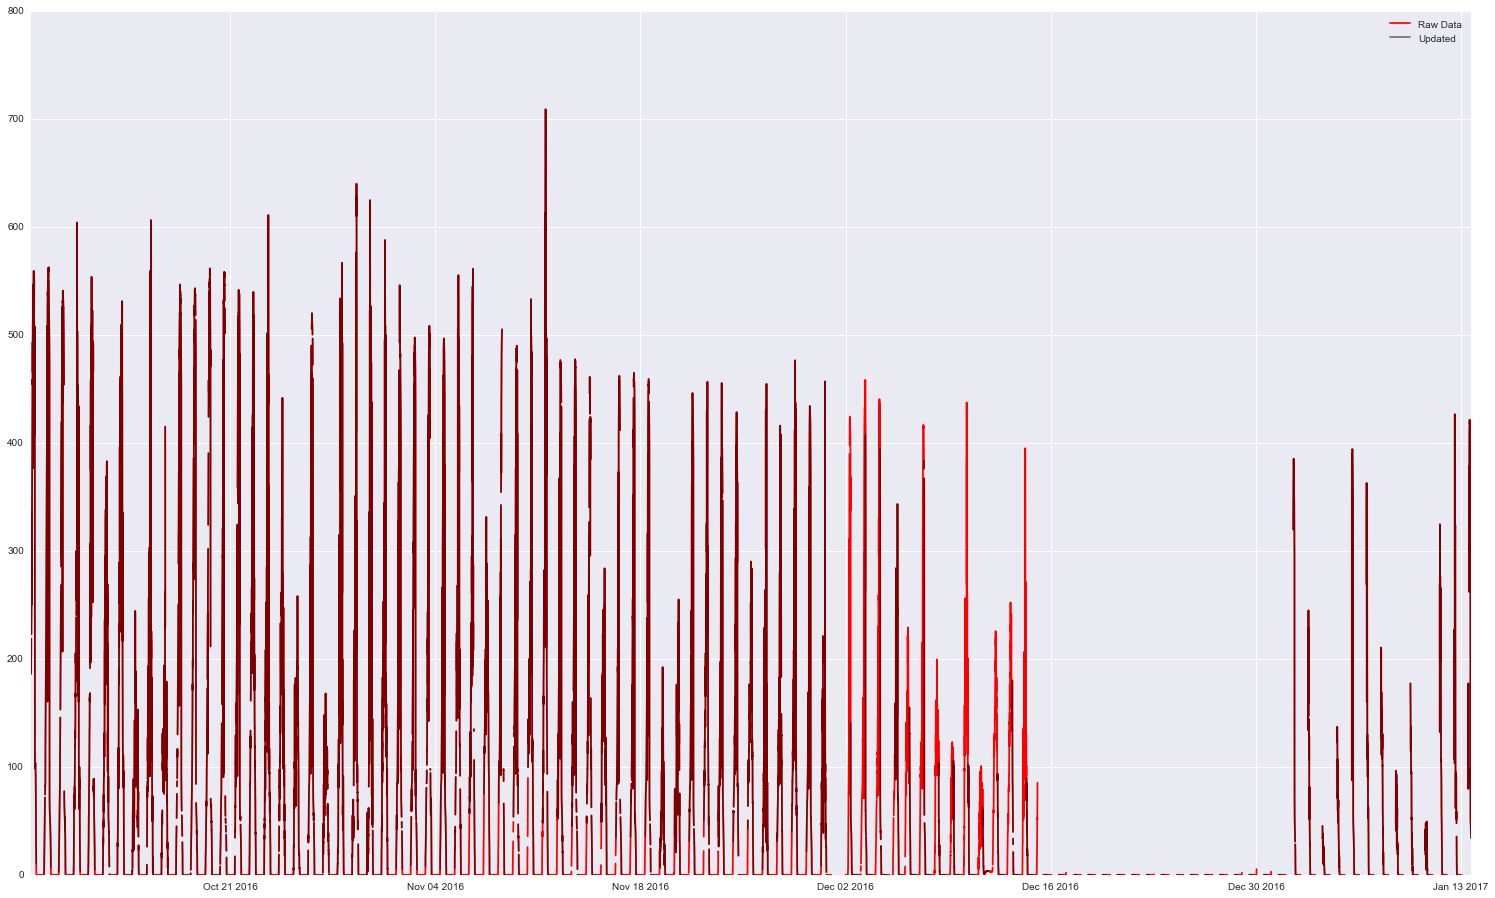

In [95]:
fig = plt.figure(figsize = (20,12))
axes = fig.add_axes([0,0,1,1])
axes.plot(rawLights["Solar Rad"], label = "Raw Data", color = "red")
axes.plot(rawLights["New Solar Rad"], label = "Updated", alpha = .5, color = "black")

axes.legend()

# Dark red indicates where data falls within average daylight hours, bright red indicated where it falls outside range

(0.0, 86100.0)

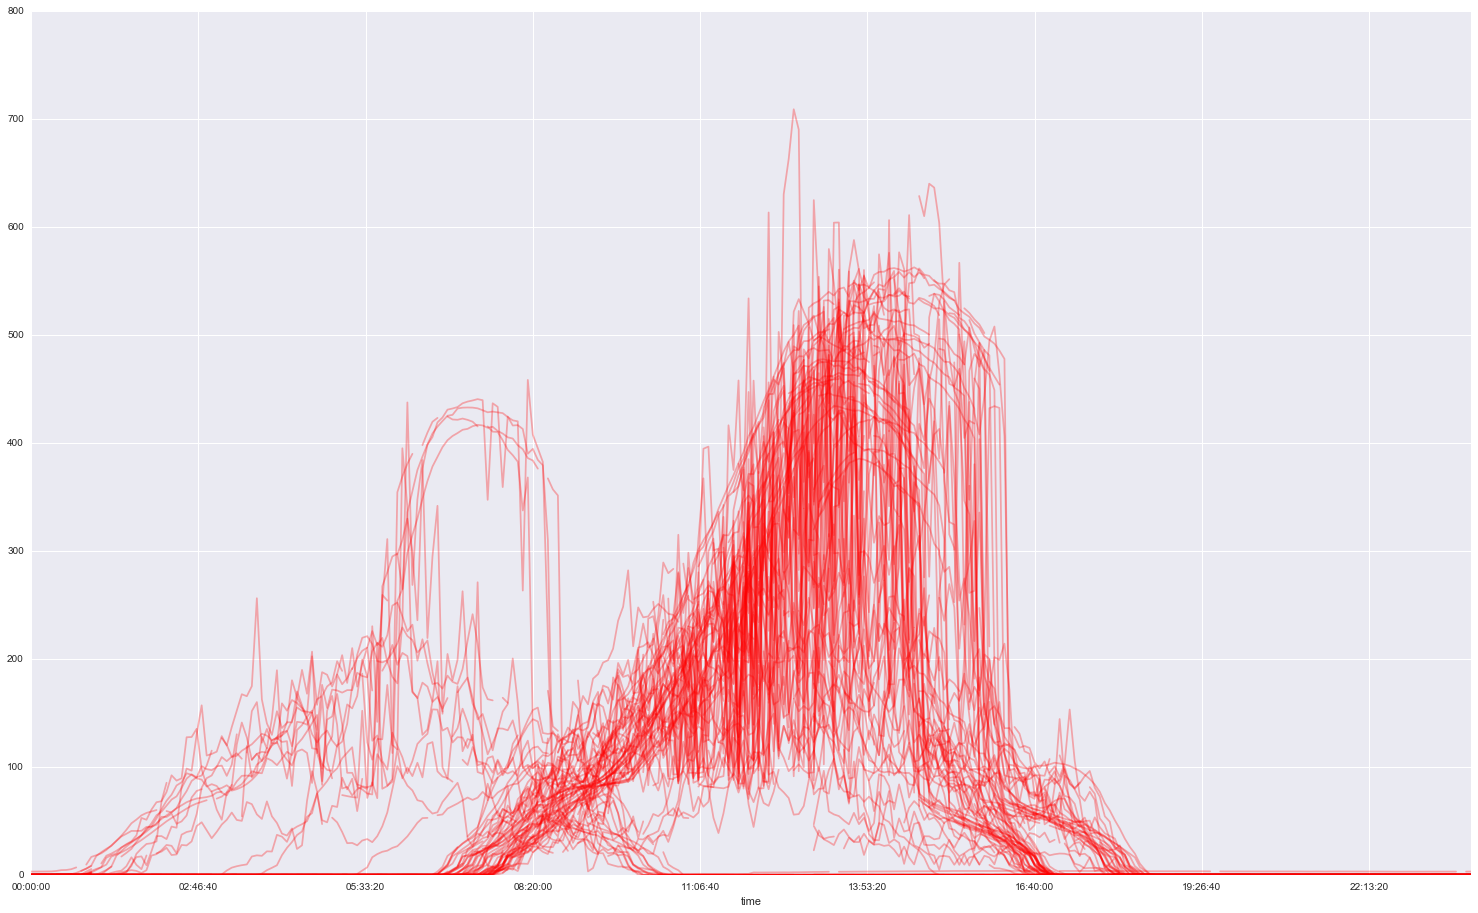

In [113]:
# Raw Solar radiation data overlayed over one another over study period

fig = plt.figure(figsize = (20,12))
axes = fig.add_axes([0,0,1,1])

for x in rawLights["Date"].unique():
    axes.plot(rawLights[rawLights["Date"] == x].groupby("Time")["Solar Rad"].mean(), color = "red", alpha = .3)

axes.set_xlim([datetime.time(0,0), datetime.time(23,55)])

(0.0, 86100.0)

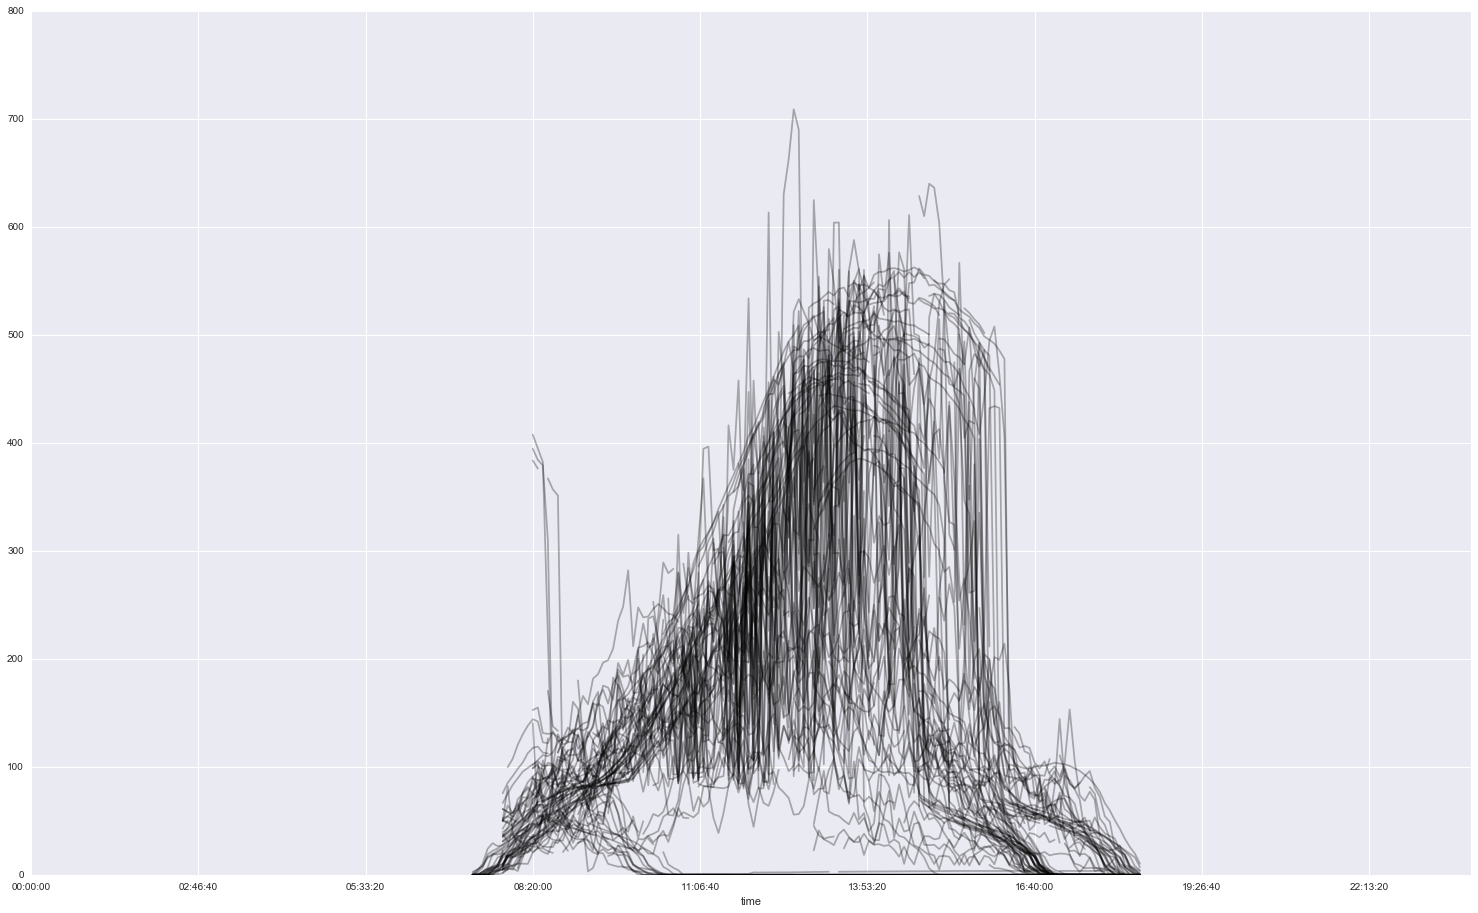

In [107]:
# Data remaining after daylight hours filtering 

fig = plt.figure(figsize = (20,12))
axes = fig.add_axes([0,0,1,1])

for x in rawLights["Date"].unique():
    axes.plot(rawLights[rawLights["Date"] == x].groupby("Time")["New Solar Rad"].mean(), color = "black", alpha = .3)

axes.set_xlim([datetime.time(0,0), datetime.time(23,55)])

#### Smooth Solar Radiation Data

In [283]:
# Smoothed solar radiation data/ Mean of 30 minute intervals
smooth = pd.DataFrame()
n = 0
for x in rawLights["Date"].unique():
    if n == 0:
        smooth = pd.DataFrame(rawLights[rawLights["Date"] == x].groupby(pd.TimeGrouper(freq = "30 Min"))["New Solar Rad"].mean().dropna())
        n+=1
    else:
        smooth = pd.concat([smooth, pd.DataFrame(rawLights[rawLights["Date"] == x].groupby(pd.TimeGrouper(freq = "30 Min"))["New Solar Rad"].mean().dropna())])

In [284]:
timeValues(smooth)
smooth["Date"] = [x.date() for x in smooth.index.tolist()]
smooth["Time"] = [x.time() for x in smooth.index.tolist()]
smooth.columns = ['Smooth Solar Rad', 'Month', 'Day', 'Hour', 'Minute', 'Day of Week',
       'Date', 'Time']

In [285]:
rawLights = rawLights.join(pd.DataFrame(smooth["Smooth Solar Rad"]), how = "left")
rawLights["Smooth Solar Rad"].fillna(method = "ffill", inplace = True)

(0.0, 86100.0)

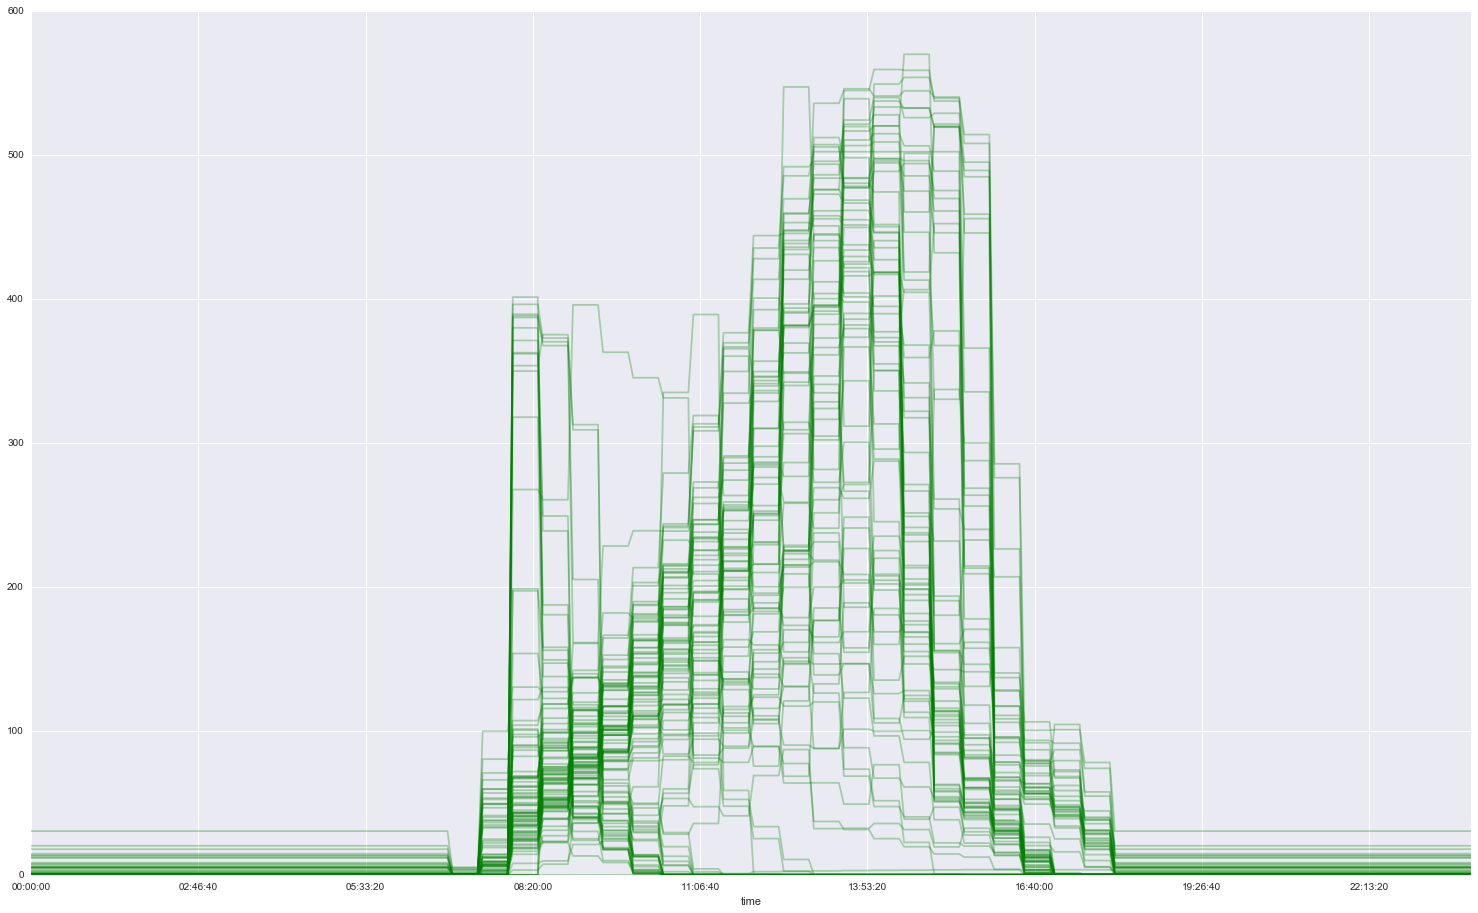

In [286]:
fig = plt.figure(figsize = (20,12))
axes = fig.add_axes([0,0,1,1])

for x in rawLights["Date"].unique():
    axes.plot(rawLights[rawLights["Date"] == x].groupby("Time")["Smooth Solar Rad"].mean(), color = "green", alpha = .3)

axes.set_xlim([datetime.time(0,0), datetime.time(23,55)])

In [96]:
# Count of when solar radiation is zero, data seems to follow a normal daily profile. 0's normally lie in the 
rawLights[rawLights["Solar Rad"] == 0].groupby("Time")["Solar Rad"].count().iplot(fill='tonexty')

In [287]:
rawLights.describe()

,School Day,School Hours,Illum,Second Illum,Either Light,Average Illum,Solar Rad,Month,New Solar Rad,Smooth Solar Rad
count,157775.000000,157775.000000,149281.000000,0.0,42318.000000,149281.000000,140809.000000,157775.000000,60013.000000,157775.000000
mean,0.536352,0.323194,3.991193,NaN,0.267640,3.991193,61.510668,9.540713,115.904977,50.403259
std,0.498678,0.467698,6.936920,NaN,0.442734,6.936920,116.585839,3.771891,144.331255,106.768641
min,0.000000,0.000000,0.400000,NaN,0.000000,0.400000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.400000,NaN,0.000000,0.400000,0.000000,10.000000,0.000000,0.000000
50%,1.000000,0.000000,1.100000,NaN,0.000000,1.100000,0.000000,11.000000,62.430000,0.000000
75%,1.000000,1.000000,3.300000,NaN,1.000000,3.300000,76.960000,12.000000,159.770000,43.168000
max,1.000000,1.000000,59.700000,NaN,1.000000,59.700000,708.820000,12.000000,708.820000,569.808000


//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



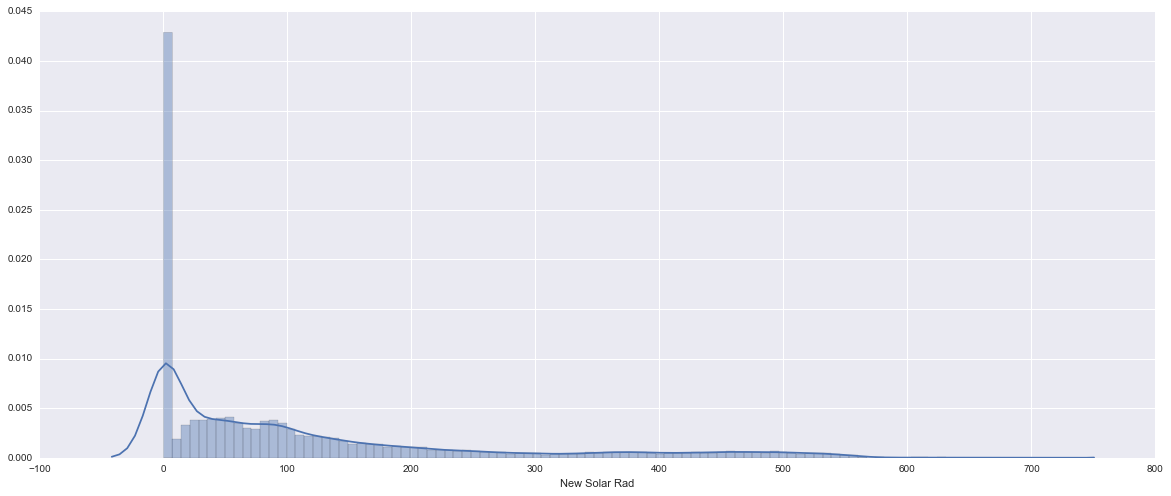

In [14]:
plt.figure(figsize = (20,8))
sns.distplot(rawLights["New Solar Rad"].dropna(), bins = 100)

#### Filter out night like data

In [288]:
nightSolar = []
for month, time, solar in zip(rawLights["Month"],
                              rawLights["Time"],
                              rawLights["Smooth Solar Rad"]):
    if month == 10:
        if timeRange(datetime.time(7,20), datetime.time(18,25), time):
            pass
        else:
            nightSolar.append(solar)
    elif month == 11:
        if timeRange(datetime.time(7,50), datetime.time(18,0), time):
            pass
        else:
            nightSolar.append(solar)
    elif month == 12:
        if timeRange(datetime.time(8,20), datetime.time(17,50), time):
            pass
        else:
            nightSolar.append(solar)
    elif month == 1:
        if timeRange(datetime.time(8,25), datetime.time(18,10), time):
            pass
        else:
            nightSolar.append(solar)
    else:
        pass

print(np.mean(nightSolar))
print(np.max(nightSolar))
print(np.std(nightSolar))

4.04628047909
401.165
25.1985095646


In [56]:
# Remove data with a smooth solar radiation less than 25

#### Solar Radiation vs Illuminance Regression

In [15]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [17]:
def solarRegression(room):
    
    holder = rawLights[(rawLights["Room"] == str(room)) & 
                  (rawLights["Either Light"] == 0)][
                    ["Average Illum", "Solar Rad"]].dropna()
    
    y = holder["Solar Rad"].reshape(len(holder), 1)

    X = holder["Average Illum"].reshape(len(holder), 1)

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    lm = LinearRegression()
    
    lm.fit(X_train,y_train)
    
    solar1 = (lm.coef_* 7) + lm.intercept_
    solar2 = (lm.coef_* 14) + lm.intercept_
    
    predictions = lm.predict(X_test)
    
    print(room)
    
    plt.figure(figsize = (18,8))
    
    plt.title("Room " + str(x))
    plt.xlabel("Solar Radiation")
    plt.ylabel("Average Illum")
    
    plt.scatter(y,X)
    
    print("Adequate: ", solar1)
    print("Exceptional", solar2)

In [18]:
from sklearn import metrics

In [19]:
def solarRegression2(room):
    
    if room == "5402":
        holder = rawLights[(rawLights["Room"] == "5402") & 
          (rawLights["Average Illum"] <= 15) & 
          (rawLights["New Solar Rad"] >= 5)][["Average Illum", "New Solar Rad"]].dropna()

    # in room 5402 there is alot of data where solar rad is low but illums in above exceptional. This is filter that out
    
    else:
        holder = rawLights[(rawLights["Room"] == str(room)) & 
                (rawLights["Either Light"] == 0)][
                ["Average Illum", "New Solar Rad"]].dropna()
        
    y = holder["New Solar Rad"].reshape(len(holder), 1)

    X = holder["Average Illum"].reshape(len(holder), 1)
    
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    lm = LinearRegression()
    
    lm.fit(X,y)
    
    solar1 = (lm.coef_* 7) + lm.intercept_
    solar2 = (lm.coef_* 14) + lm.intercept_
    
    predictions = lm.predict(X)
    
    print(room)
    
    plt.figure(figsize = (18,8))
    
    plt.title("Room " + str(x))
    plt.xlabel("Solar Radiation")
    plt.ylabel("Average Illum")
    
    plt.scatter(y,X)

#     plt.title("Room " + str(x))
#     plt.xlabel("Predictions")
#     plt.ylabel("Actual")
    
#     plt.scatter(y_test, predictions)
    
    print("R Squared:", metrics.explained_variance_score(y,predictions))
    
    print("Adequate: ", solar1)
    print("Exceptional", solar2)
    print(" ")
    print("----------------------------------")
    print(" ")

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



5210
R Squared: 0.554750480452
Adequate:  [[ 138.60139577]]
Exceptional [[ 265.32527682]]
 
----------------------------------
 
5305
R Squared: 0.06787785887
Adequate:  [[ 163.07923496]]
Exceptional [[ 252.08200073]]
 
----------------------------------
 
5402
R Squared: 0.311813114412
Adequate:  [[ 167.46149191]]
Exceptional [[ 359.43217731]]
 
----------------------------------
 
5B09
R Squared: 0.0219501819512
Adequate:  [[ 130.86199193]]
Exceptional [[ 189.74193534]]
 
----------------------------------
 
5114
R Squared: 0.0206678973431
Adequate:  [[ 216.29312617]]
Exceptional [[ 354.34677674]]
 
----------------------------------
 


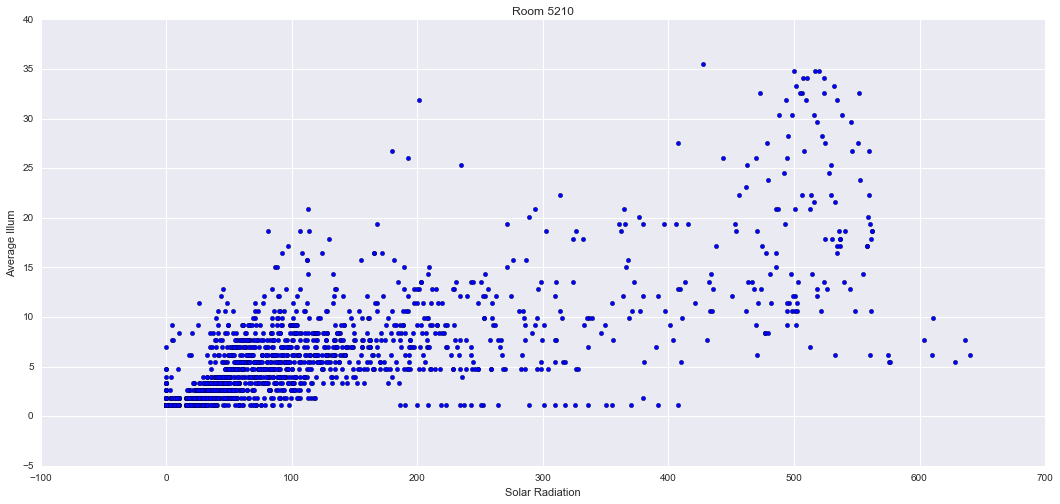

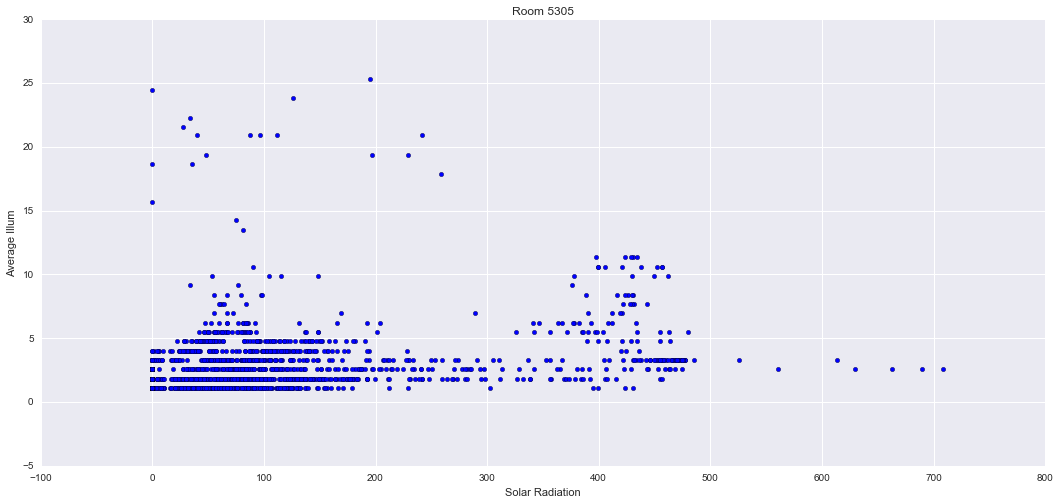

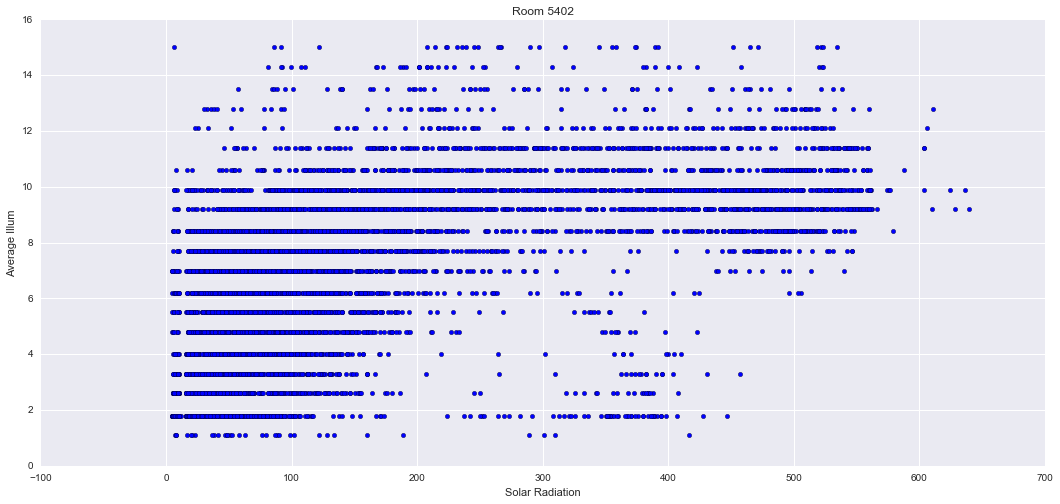

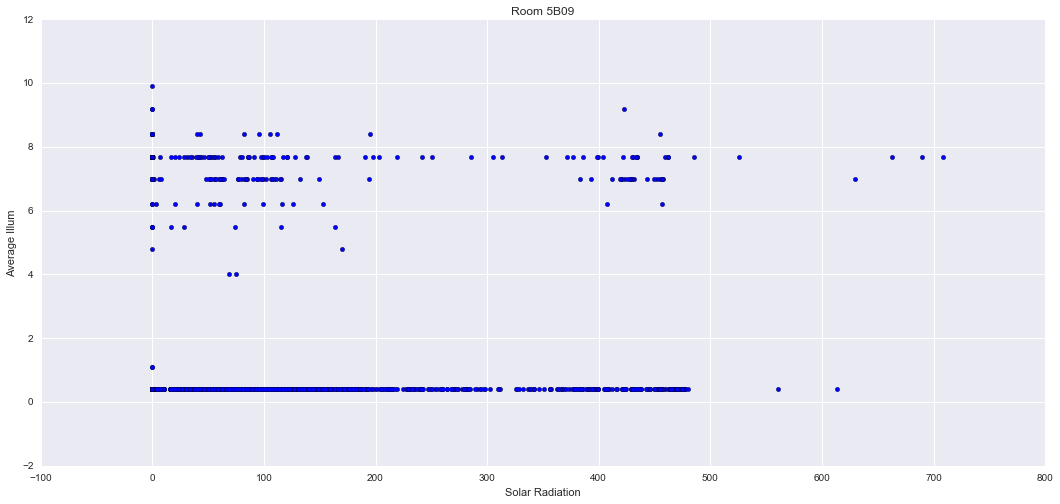

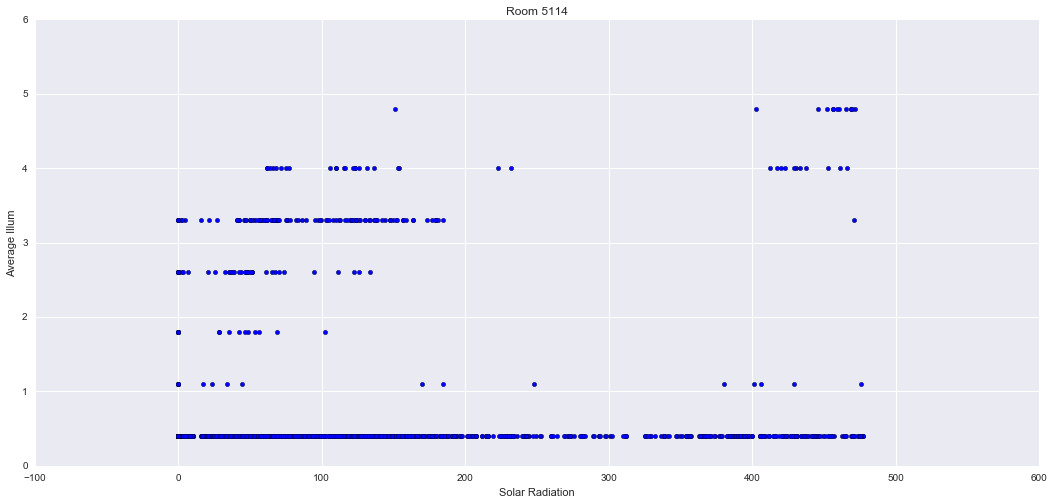

In [69]:
for x in rawLights["Room"].unique().tolist():
    solarRegression2(x)

In [291]:
def newRegression(room):
    
    #filtering out nightlike data and removing average illum values where curtains seem to be closed
    
    if room == "5402":
        holder = rawLights[(rawLights["Room"] == "5402") &
                           (rawLights["Average Illum"] >= 1) & 
                           (rawLights["New Solar Rad"] >= 25) &
                           (rawLights["Either Light"] == 0)][["Average Illum", "New Solar Rad"]].dropna()
        
    elif room == "5B09":
        holder = rawLights[(rawLights["Room"] == "5B09") &
                           (rawLights["Average Illum"] >= 1) & 
                           (rawLights["New Solar Rad"] >= 25) &
                           (rawLights["Either Light"] == 0)][["Average Illum", "New Solar Rad"]].dropna()
    
    elif room == "5114":
        holder = rawLights[(rawLights["Room"] == "5114") &
                           (rawLights["Average Illum"] >= 1) &
                           (rawLights["New Solar Rad"] >= 25) &
                           (rawLights["Either Light"] == 0)][["Average Illum", "New Solar Rad"]].dropna()
    
    else:
        holder = rawLights[(rawLights["Room"] == str(room)) & 
                (rawLights["Either Light"] == 0) &
                (rawLights["New Solar Rad"] >= 25)][["Average Illum", "New Solar Rad"]].dropna()
        
    y = holder["New Solar Rad"]

    X = holder["Average Illum"]
    
    
    polyFit = np.polyfit(X,y, deg = 1)
    
    predictor = np.poly1d(polyFit)
    
    solar1 = predictor(7)
    solar2 = predictor(14)
    
    predictions = predictor(X)
    
    print(room)
    
    plt.figure(figsize = (18,8))
    
    plt.title("Room " + str(x))
    plt.xlabel("Solar Radiation")
    plt.ylabel("Average Illum")
    
    plt.scatter(y,X)
    
    print("R Squared:", metrics.explained_variance_score(y,predictions))
    
    print("Adequate: ", solar1)
    print("Exceptional", solar2)
    print(" ")
    print("----------------------------------")
    print(" ")

5210
R Squared: 0.478740798688
Adequate:  148.491776584
Exceptional 265.548567998
 
----------------------------------
 
5305
R Squared: 0.0380295544876
Adequate:  179.516037148
Exceptional 243.660844073
 
----------------------------------
 
5402
R Squared: 0.0809970397122
Adequate:  93.2500948579
Exceptional 147.959579743
 
----------------------------------
 
5B09
R Squared: 0.0181834082342
Adequate:  194.691828311
Exceptional 414.055993992
 
----------------------------------
 
5114
R Squared: 0.130517674544
Adequate:  367.288275611
Exceptional 772.969232867
 
----------------------------------
 


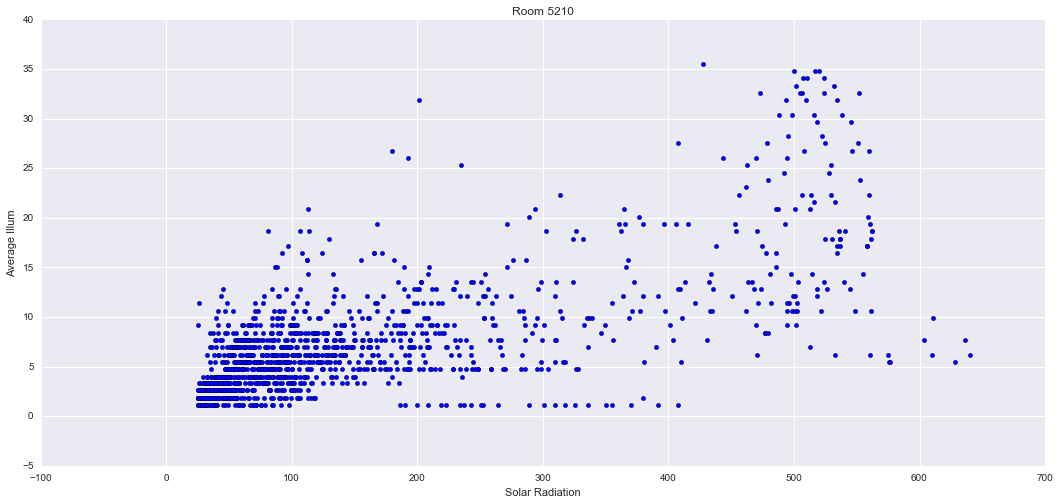

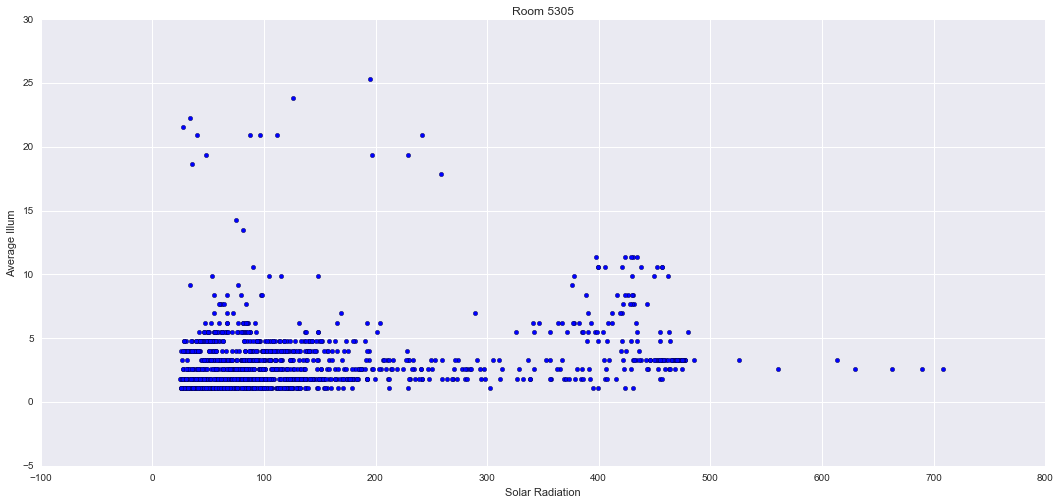

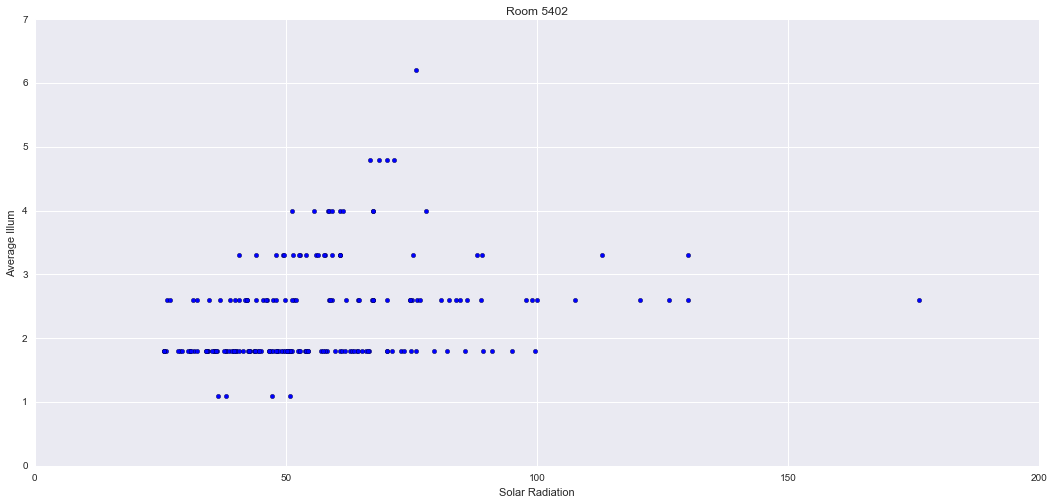

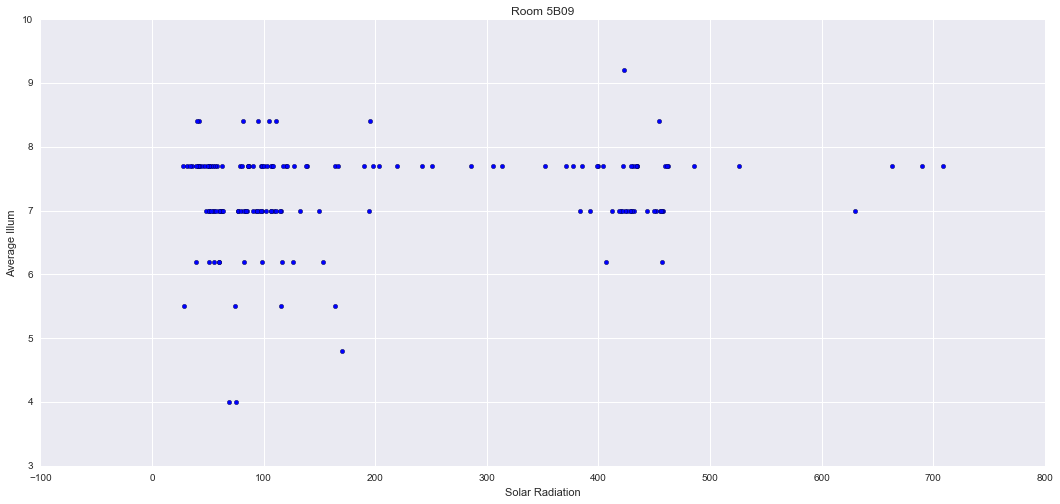

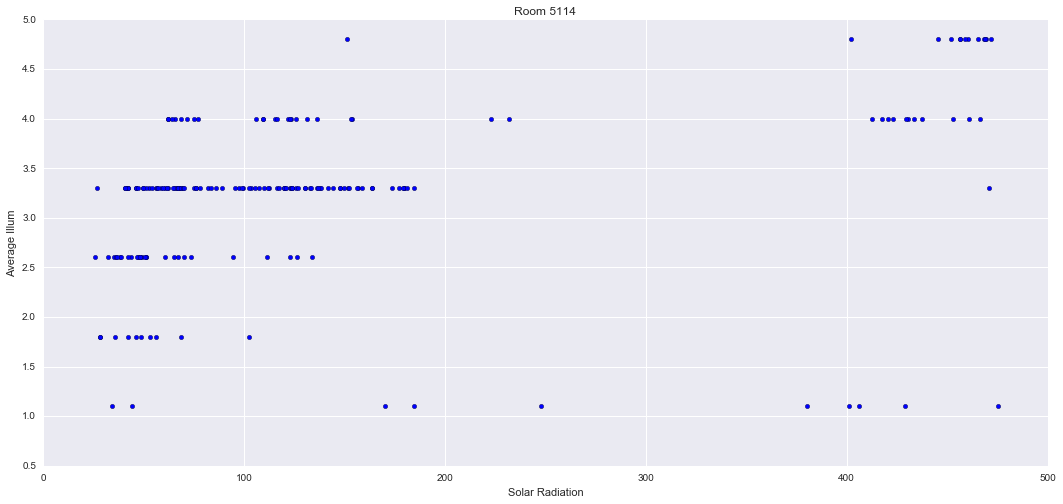

In [292]:
for x in rawLights["Room"].unique().tolist():
    newRegression(x)

#### Ploynomial Regression

In [289]:
# testing out polynomial regression however this best fit is with a degree of freedom of one

def polyRegression(room):
    
    if room == "5402":
        holder = rawLights[(rawLights["Room"] == "5402") & 
          (rawLights["Average Illum"] >= 1) & 
          (rawLights["New Solar Rad"] >= 25) &
            (rawLights["Either Light"] == 0)][["Average Illum", "Smooth Solar Rad"]].dropna()
        
    elif room == "5B09":
        holder = rawLights[(rawLights["Room"] == "5B09") &
                           (rawLights["Average Illum"] >= 1) & 
                           (rawLights["New Solar Rad"] >= 25) &
                            (rawLights["Either Light"] == 0)][["Average Illum", "Smooth Solar Rad"]].dropna()
    
    elif room == "5114":
        holder = rawLights[(rawLights["Room"] == "5114") &
                           (rawLights["Average Illum"] >= 1) &
                           (rawLights["New Solar Rad"] >= 25) &
                            (rawLights["Either Light"] == 0)][["Average Illum", "Smooth Solar Rad"]].dropna()
    
    else:
        holder = rawLights[(rawLights["Room"] == str(room)) & 
                (rawLights["Either Light"] == 0) &
                (rawLights["New Solar Rad"] >= 25)][["Average Illum", "Smooth Solar Rad"]].dropna()

    # Using the smoothed solar radiation data to the volitility that came with cloud coverage
        
    y = holder["Smooth Solar Rad"]

    X = holder["Average Illum"]
    
    
    polyFit = np.polyfit(X,y, deg = 1)
    
    predictor = np.poly1d(polyFit)
    
    solar1 = predictor(7)
    solar2 = predictor(14)
    
    predictions = predictor(X)
    
    print(room)
    
    plt.figure(figsize = (18,8))
    
    plt.title("Room " + str(x))
    plt.xlabel("Smoothed Solar Radiation")
    plt.ylabel("Average Illum")
    
    plt.scatter(y,X)
    
    print("R Squared:", metrics.explained_variance_score(y,predictions))
    
    print("Adequate: ", solar1)
    print("Exceptional", solar2)
    print(" ")
    print("----------------------------------")
    print(" ")

5210
R Squared: 0.499543749319
Adequate:  149.143188992
Exceptional 263.141060897
 
----------------------------------
 
5305
R Squared: 0.0423217180776
Adequate:  178.949698597
Exceptional 242.085832523
 
----------------------------------
 
5402
R Squared: 0.0605638123559
Adequate:  88.805332576
Exceptional 134.935978039
 
----------------------------------
 
5B09
R Squared: 0.0315134304166
Adequate:  193.197815797
Exceptional 461.263280572
 
----------------------------------
 
5114
R Squared: 0.155710464002
Adequate:  359.244415603
Exceptional 759.20305304
 
----------------------------------
 


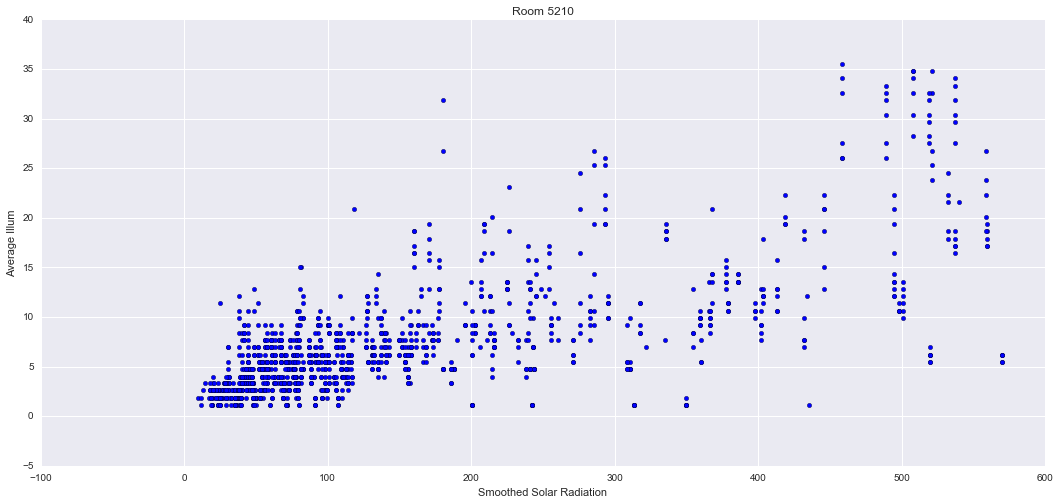

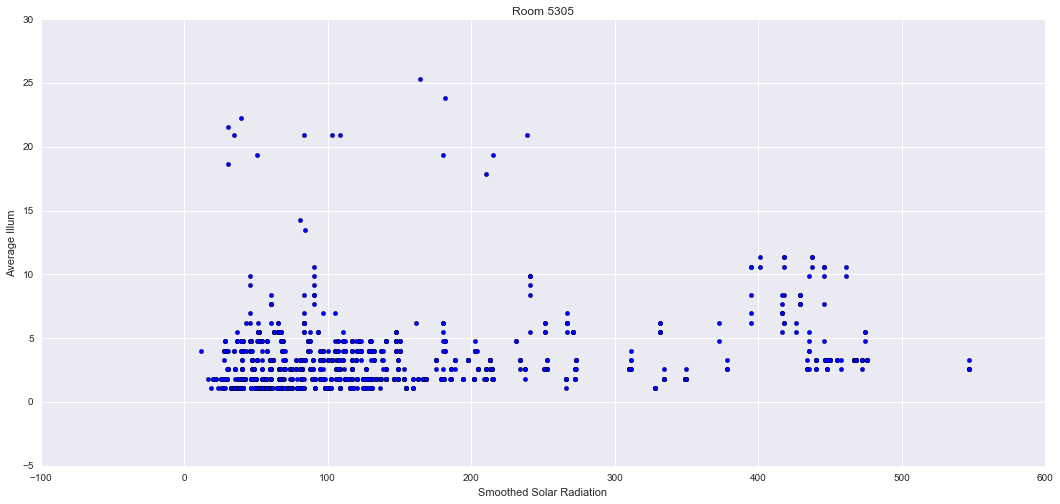

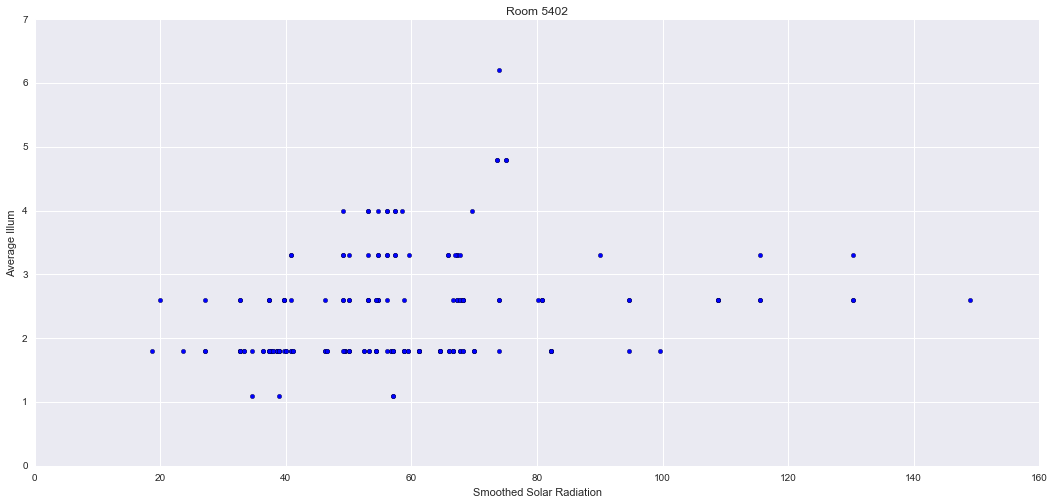

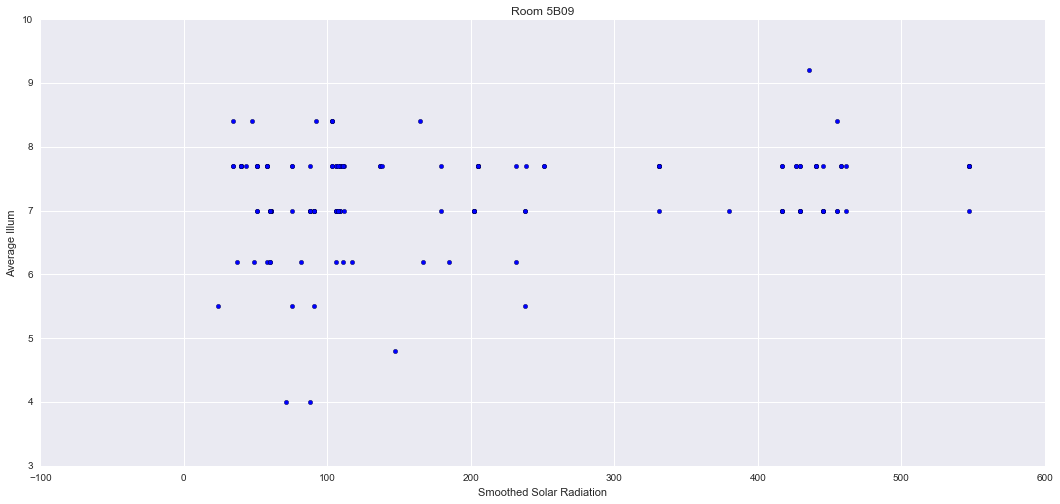

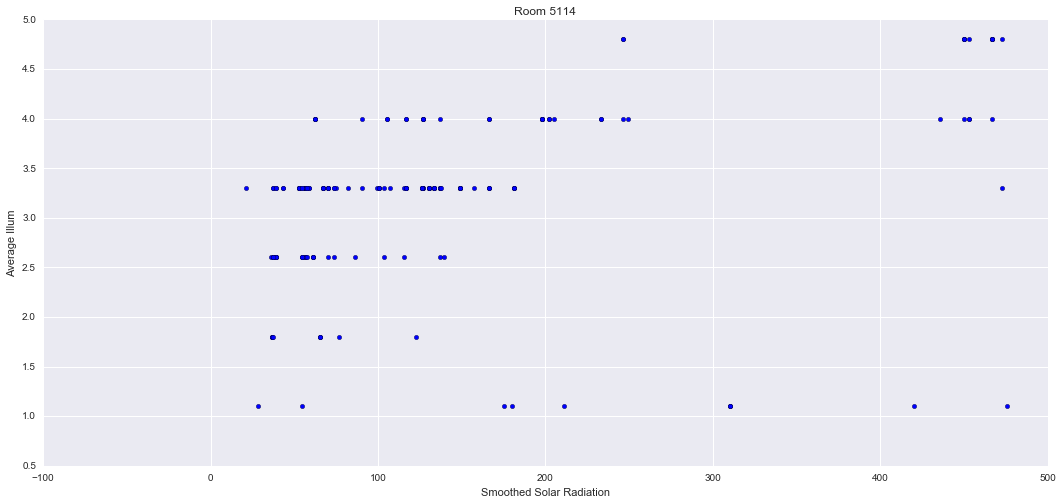

In [290]:
for x in rawLights["Room"].unique().tolist():
    polyRegression(x)

#### Upper Right Quadrant Deeper Look

In [294]:
# for room in rawLights["Room"].unique().tolist():
#     if room == "5402":
#         holder = rawLights[(rawLights["Room"] == "5402") & 
#           (rawLights["Average Illum"] >= 1) & 
#           (rawLights["New Solar Rad"] >= 21) &
#             (rawLights["Either Light"] == 0)][["Average Illum", "New Solar Rad"]].dropna()
        
#     elif room == "5B09":
#         holder = rawLights[(rawLights["Room"] == "5B09") &
#                            (rawLights["Average Illum"] >= 1) & #Removing drawn curtins 
#                            (rawLights["New Solar Rad"] >= 21) &
#                             (rawLights["Either Light"] == 0)][["Average Illum", "New Solar Rad"]].dropna()
    
#     elif room == "5114":
#         holder = rawLights[(rawLights["Room"] == "5114") &
#                            (rawLights["Average Illum"] >= 1) &
#                            (rawLights["New Solar Rad"] >= 21) &
#                             (rawLights["Either Light"] == 0)][["Average Illum", "New Solar Rad"]].dropna()
    
#     else:
#         holder = rawLights[(rawLights["Room"] == str(room)) & 
#                 (rawLights["Either Light"] == 0) &
#                 (rawLights["New Solar Rad"] >= 21)][["Average Illum", "New Solar Rad"]].dropna()



#     holder["Hour"] = [x.hour for x in holder.index.tolist()]
#     holder["Date"] = [x.date() for x in holder.index.tolist()]

#     print(room)
#     print(" ")
# #     print(holder[(holder["New Solar Rad"] < 200) & (holder["Average Illum"] > 5)].groupby("Date")["Date"].count())
#     print(holder[(holder["New Solar Rad"] < 200) & (holder["Average Illum"] > 5)].groupby("Hour")["Hour"].count())
#     print("-------------------")
#     print(" ")

#### Exceptional Values decided on (Amy and I had a discussion informed by smoothed data)

In [295]:
# 5210: 270 w/m^2
# 5305: 250 w/m^2
# 5402: 220 w/m^2
# 5B09: 400 w/m^2
# 5114: 460 w/m^2

In [296]:
# calculating percentage of time when no lights were needed
# calculating the percentage of time when no lights were needed but lights were used
# zip with room number and its respective minimum solar radiation levels 

for room, value in zip(["5B09", "5210", "5402", "5305", "5114"], [400, 270, 220, 250, 460]):
    above = 0
    for solar in rawLights[(rawLights["Room"] == room) & 
                            (rawLights["School Day"] == 1) & 
                            (rawLights["School Hours"] == 1)]["New Solar Rad"].dropna():
        if solar >= value:
            above+=1
        else:
            pass
        
    print(room)
    print("Data Point Count")
    print(rawLights[(rawLights["Room"] == room) & 
                        (rawLights["School Day"] == 1) & 
                        (rawLights["School Hours"] == 1)]["Solar Rad"].dropna().count())

    print(" ")
    print("No Lights Needed %")
    print(above/rawLights[(rawLights["Room"] == room) & 
                        (rawLights["School Day"] == 1) & 
                        (rawLights["School Hours"] == 1)]["Solar Rad"].count())

    print(" ")
    print("Lights on % When Not Needed")
    print(rawLights[(rawLights["Room"] == room) & 
                        (rawLights["School Day"] == 1) & 
                        (rawLights["School Hours"] == 1) &
                        (rawLights["Solar Rad"] >= value) &
                        (rawLights["Either Light"] == 1)]["Solar Rad"].count() / rawLights[(rawLights["Room"] == room) & 
                        (rawLights["School Day"] == 1) & 
                        (rawLights["School Hours"] == 1)]["Solar Rad"].count())
    
    print("-----------------")

5B09
Data Point Count
4559
 
No Lights Needed %
0.125027418293
 
Lights on % When Not Needed
0.022592673832
-----------------
5210
Data Point Count
5766
 
No Lights Needed %
0.184530003469
 
Lights on % When Not Needed
0.110301768991
-----------------
5402
Data Point Count
4606
 
No Lights Needed %
0.256838905775
 
Lights on % When Not Needed
0.0481980026053
-----------------
5305
Data Point Count
4605
 
No Lights Needed %
0.225407166124
 
Lights on % When Not Needed
0.0330076004343
-----------------
5114
Data Point Count
4572
 
No Lights Needed %
0.075678040245
 
Lights on % When Not Needed
0.00262467191601
-----------------


In [297]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Question Three")
daylight7 = pd.read_excel("Natural vs Electric Lighting 7.xlsx", index_col = 0)
daylight14 = pd.read_excel("Natural vs Electric Lighting 14.xlsx", index_col = 0)

In [298]:
# fig1 = plt.figure(figsize = (20,12))
# ind = np.arange(5)    # the x locations for the groups
# width = 0.35       # the width of the bars: can also be len(x) sequence

# p1 = plt.bar(ind, daylight7["No Lights Needed %"],   width, color='#80d68b')
# p2 = plt.bar(ind, daylight7["Lights on % When Not Need"], width, color='#28542d', bottom = daylight7["No Lights Needed %"])

# plt.ylabel('Percentage of Time Daylight Used in Classroom')
# plt.title('Percentage of Time when Room Can Be Naturally Lit (7 Footcandles)')
# plt.xticks(ind+width/2., ('5210', '5305', '5402', '5B09', '5114') )
# plt.legend( (p1[0], p2[0]), ('Lights used when day light adequate','Daylight used when daylight adequate') )


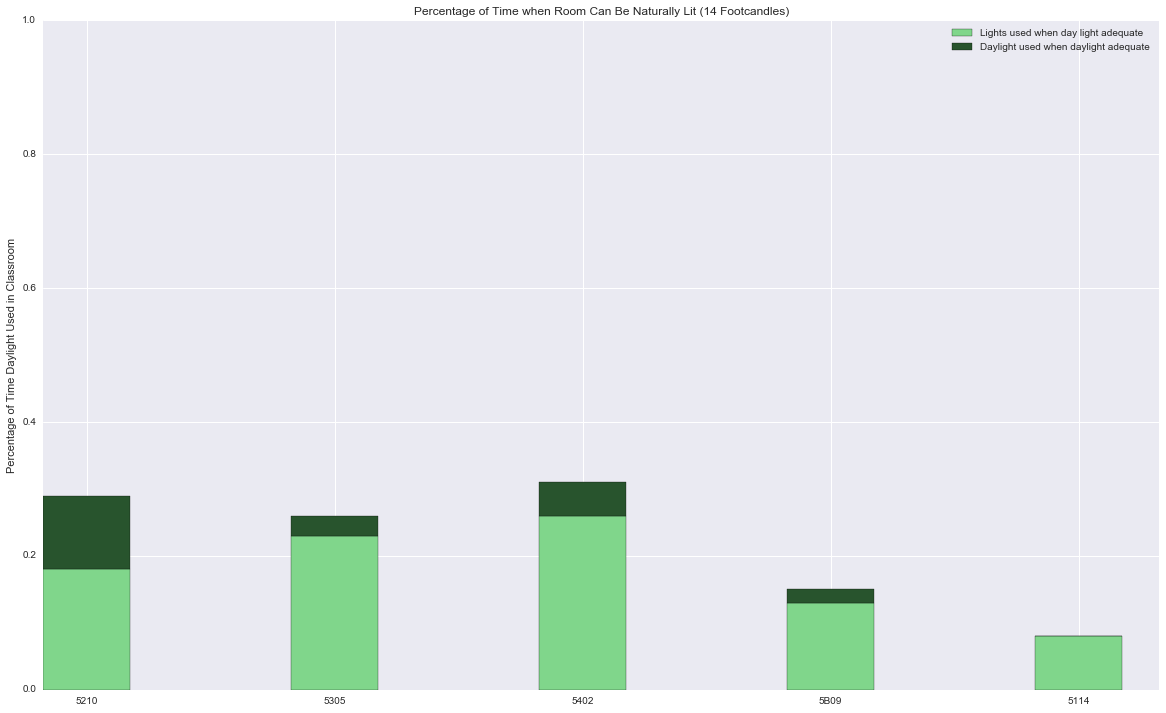

In [300]:
fig1 = plt.figure(figsize = (20,12))
ind = np.arange(5)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, daylight14["No Lights Needed %"],   width, color='#80d68b')
p2 = plt.bar(ind, daylight14["Lights on % When Not Need"], width, color='#28542d', bottom = daylight14["No Lights Needed %"])

plt.ylabel('Percentage of Time Daylight Used in Classroom')
plt.title('Percentage of Time when Room Can Be Naturally Lit (14 Footcandles)')
plt.ylim([0,1])
plt.xticks(ind+width/2., ('5210', '5305', '5402', '5B09', '5114') )
plt.legend( (p1[0], p2[0]), ('Lights used when day light adequate','Daylight used when daylight adequate') )

In [245]:
fig1.savefig("Percentage of Time Naturally Lit 7.pdf")
fig2.savefig("Percentage of Time Naturally Lit 14.pdf")

### Outdoor PMV

In [8]:
#Input Unit of Measure

    # airTemp = Fahrenheit
    # relativeHumidity = Whole Number (eg. 85)
    # Mean Radiant Temp = Fahrenheit
    # airSpeed = Miles per Hour
    # cloValue = Clo
    # metRate = Met

def PMV(airTemp, relativeHum, MRT, airSpeed, cloValue, metRate):
    
    # Returns PMV
    # ta, airTemp, Celcius
    # tr, mean radiant temperature, Celcius
    # vel, relative air velocity, (m/s)
    # rh, relative humidity (%) Used only this way to input humidity level
    # met, metabolic rate, (met)
    # clo, clothing (clo)
    # wme, external work, normally around 0
    
    
    #Conversion of units of measure
    
    ta = (airTemp - 32)/1.8
    tr = (MRT - 32)/1.8
    vel = airSpeed * .44704   
    pa = relativeHum * 10 * math.exp(16.6536 - 4030.183 / (ta + 235))
    
    #Thermal Insulation of the clothing in M2K/W
    
    icl = 0.155 * cloValue
    
    #Metabolic Rate in W/M2
    
    m = metRate * 58.15
    
    #External Work in W/M2
    
    w = .001 * 58.15
    
    #Internal heat production of the human body
    
    mw = m - w
    if icl <= .078:
        fcl = 1 + (1.29 * icl)
    else:
        fcl = 1.05 + (.645 * icl)
    
    #Heat transfer coefficient by forced convection
    
    hcf = 12.1 * np.sqrt(vel)
    taa = ta + 273
    tra = tr + 273
    tcla = taa + (35.5 - ta) / (3.5 * icl + 0.1)
    p1 = icl * fcl
    p2 = p1 * 3.96
    p3 = p1 * 100
    p4 = p1 * taa
    p5 = 308.7 - .028 * mw + p2 * math.pow(tra/100,4)
    xn = tcla / 100
    xf = tcla / 50
    eps = .00015
    
    n = 0
    while (np.abs(xn - xf) > eps):
        xf = (xf + xn) / 2
        hcn = 2.38 * math.pow(np.abs(100 * xf - taa), .25)
        if hcf > hcn:
            hc = hcf
        else:
            hc = hcn
        
        xn = (p5 + p4 * hc - p2 * math.pow(xf,4)) / (100 + p3 * hc)
        
        n+=1
        
        if n > 150:
            print("Max iterations exceeded")
            return 1
    
    tcl = 100 * xn - 273
    
    # Heat loss diff through skin
    
    hl1 = 3.05 * .001 * (5733 - (6.99 * mw) - pa)
    
    # Heat loss by sweating
    
    if mw > 58.15:
        hl2 = .42 * (mw - 58.15)
    else:
        hl2 = 0
    
    # Latent respiration heat loss
    
    hl3 = 1.7 * .00001 * m * (5867 - pa)
    
    # Dry respiration heat loss
    
    hl4 = .0014 * m * (34 - ta)
    
    # Heat loss by radiation
    
    hl5 = 3.96 * fcl * (math.pow(xn, 4) - math.pow(tra/100, 4))
    
    # Heat loss by convection
    
    hl6 = fcl * hc * (tcl - ta)
    
    ts = .303 * np.exp(-0.036 * m) + .028

    pmv = ts * (mw - hl1 - hl2 - hl3 - hl4 - hl5 - hl6)    
    
#     pmv = round(pmv,1)
    
    return(np.round(a = pmv, decimals = 1))

In [9]:
key = "0bfa64942618d5ec"
site = "KCASANFR506"
start = date(2016, 10, 7)
end = date(2017, 1, 13)

In [11]:
#enter start and end dates in date(Year, Month, Day) format, make sure key and site variables are set
def weatherData(start, end):
    dateRange = []
    date1 = start
    date2 = end

    delta = date2 - date1

    for x in range(delta.days + 1):
        dateRange.append((date1 + timedelta(days = x)).strftime("%Y%m%d"))
        
    data = {}
    
    for date in dateRange:
        urlstart = "http://api.wunderground.com/api/" + str(key) + "/history_"
        urlend = "/q/pws:" + str(site) + ".json"

        url = urlstart + date + urlend

        data[date] = requests.get(url).json()

        
    weatherPretty = []
    weatherYear = []
    weatherMonth = []
    weatherDay = []
    weatherHour = []
    weatherMinute = []
    weatherTemp = []
    weatherHum = []
    weatherRainRate = []
    weatherWind = []

    for x in dateRange:
        for y in range(400):
            try:
                weatherPretty.append(data[x]["history"]["observations"][y]["date"]["pretty"])
                weatherYear.append(data[x]["history"]["observations"][y]["date"]["year"])
                weatherMonth.append(data[x]["history"]["observations"][y]["date"]["mon"])
                weatherDay.append(data[x]["history"]["observations"][y]["date"]["mday"])
                weatherHour.append(data[x]["history"]["observations"][y]["date"]["hour"])
                weatherMinute.append(data[x]["history"]["observations"][y]["date"]["min"])
                weatherTemp.append(data[x]["history"]["observations"][y]["tempi"])
                weatherHum.append(data[x]["history"]["observations"][y]["hum"])
                weatherRainRate.append(data[x]["history"]["observations"][y]["precip_ratei"])
                weatherWind.append(data[x]["history"]["observations"][y]["wspdm"])
            except:
                break
    
    
    weatherData = pd.DataFrame(
        data = [weatherYear, weatherMonth, weatherDay, weatherHour, weatherMinute, 
                weatherTemp, weatherHum, weatherRainRate, weatherWind]
    ).T
    


    weatherData.columns = ["Year","Month", "Day", "Hour", "Minute", "Temp", "RH%", "Rain Rate", "Wind Speed"]
    

    weatherData["Year"] = weatherData["Year"].apply(lambda x: int(x))    
    weatherData["Month"] = weatherData["Month"].apply(lambda x: int(x))
    weatherData["Day"] = weatherData["Day"].apply(lambda x: int(x))
    weatherData["Hour"] = weatherData["Hour"].apply(lambda x: int(x))
    weatherData["Minute"] = weatherData["Minute"].apply(lambda x: int(x))
    weatherData["Temp"] = weatherData["Temp"].apply(lambda x: float(x))
    weatherData["RH%"] = weatherData["RH%"].apply(lambda x: int(x))
    weatherData["Rain Rate"] = weatherData["Rain Rate"].apply(lambda x: float(x))
    weatherData["Wind Speed"] = weatherData["Wind Speed"].apply(lambda x: float(x))
    

    weatherData["Date/Time"] = pd.to_datetime(weatherData[["Year", "Month", "Day", "Hour", "Minute"]])

    weatherData.set_index("Date/Time", inplace = True)
    
    weatherData = pd.DataFrame(weatherData)
    
#     print(weatherData)
    
    return(weatherData)

In [12]:
weather = weatherData(start, end)

In [13]:
# os.chdir("/Users/adeniyiharrison/Dropbox/488 Sacred Heart Siboni SQL Files")
# weather.to_excel("KCASANFR506_Weather.xlsx")

In [14]:
cursor.execute("SELECT date_time, station_id, solar_rad FROM siboniweather WHERE station_id = 'KCASANFR506'")
solar = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time", "Station ID", "Solar Rad"])

solar.set_index("Date/Time", inplace = True)

weather = weather.groupby(pd.TimeGrouper(freq = "5 Min"))[["Temp", "RH%", "Wind Speed"]].mean()
weather = weather.join(pd.DataFrame(solar["Solar Rad"]))
weather["Solar Rad"] = weather["Solar Rad"].apply(lambda x: convert(x))
weather.dropna(inplace = True)
timeValues(weather)

In [15]:
mrt = []
for x, y in zip(weather["Solar Rad"], weather["Temp"]):
    if x >= 1000:
        mrt.append(170)
    elif x > 900 and x < 999:
        mrt.append(160)
    elif x > 800 and x < 900:
        mrt.append(155)
    elif x > 700 and x < 800:
        mrt.append(150)
    elif x > 600 and x < 700:
        mrt.append(145)
    elif x > 500 and x < 600:
        mrt.append(140)
    elif x > 400 and x < 500:
        mrt.append(135)
    elif x > 300 and x < 400:
        mrt.append(130)
    else:
        mrt.append(y)

weather["MRT"] = mrt

In [16]:
pmvValues = []
for temp, rh, mrt, wind in zip(weather["Temp"], weather["RH%"], weather["MRT"], weather["Wind Speed"]):
    x = PMV(temp, rh, mrt, wind, 1, 1.1)
    if x > 3:
        pmvValues.append(3)
    elif x < -3:
        pmvValues.append(-3)
    else:
        pmvValues.append(x)

weather["PMV"] = pmvValues

In [17]:
weather["PMV"].describe()

count    26409.000000
mean        -1.909148
std          1.384052
min         -3.000000
25%         -3.000000
50%         -2.200000
75%         -1.500000
max          3.000000
Name: PMV, dtype: float64

In [18]:
pmvData = weather[["Month", "Day", "Hour", "Minute", "PMV"]]
time = []
for x in pmvData.reset_index()["Date/Time"]:
    time.append(x.time())

pmvData["Time"] = time

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [19]:
pmvAverage = pd.DataFrame(pmvData.groupby("Time")["PMV"].mean())

In [20]:
pmvAverage.iplot()

In [21]:
timePeriod = []
percent = []
for x in pmvAverage.index.tolist():
    timePeriod.append(x)
    
    value = 0
    for y in pmvData[pmvData["Time"] == x]["PMV"].dropna():
        if -.5 <= y <= .5:
            value+=1
        else:
            pass
    
    percent.append(value/pmvData[pmvData["Time"] == x]["PMV"].dropna().count())
            

In [22]:
thermalPercent = pd.DataFrame(data = percent, index = timePeriod, columns = ["Percentage in Thermal Range"])

In [23]:
layout = go.Layout(
        yaxis = dict(range=[0, 1]))

thermalPercent.iplot(fill = "tonexty", xTitle = "Time of Day", yTitle = "Percentage of Time in Thermal Comfort Range",
                    title = 'Time of Day When Outdoor Conditions are in Thermal Comfort Range', layout = layout)

### % of time PMV is better or worse than outside PMV

In [27]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Raw PMV Data All Days")
rawPMV = pd.read_excel("Full Raw All Days PMV Data.xlsx", index_col = 0)
rawPMV["Average"] = np.mean(rawPMV, axis = 1)
rawPMV["Time"] = [x.time() for x in rawPMV.index]
indoorPMVAvg = rawPMV.groupby("Time")["Average"].mean().dropna()
comparePMV = pmvAverage.join(indoorPMVAvg)

In [50]:
comparePMV["Hour"] = [x.hour for x in comparePMV.index]
comparePMV.columns = ["Outdoor", "Indoor", "Hour"]

In [57]:
better = []
for outdoor,indoor in zip(comparePMV["Outdoor"], comparePMV['Indoor']):
    if indoor > outdoor:
        better.append(1)
    else:
        better.append(0)
        
comparePMV["Indoor Better"] = better

In [68]:
percent = comparePMV.groupby("Hour")["Indoor Better"].sum()/12

In [72]:
percent.iplot(kind = "bar", title = "% of Hour When Outdoor PMV is better than Indoor PMV", 
              yTitle = "% of Time", xTitle = "Time of Day")

In [77]:
thermalPercent["Hour"] = [x.hour for x in thermalPercent.index]

In [83]:
percentThermal = thermalPercent.groupby("Hour")["Percentage in Thermal Range"].mean()

In [86]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Question Three")
pd.DataFrame(percentThermal).to_excel("Percentage of Time Outdoor PMV Range.xlsx")

### Indoor Environmental Quality

##### Air Quality (CO2 ppm)

In [311]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Question One")
airQuality = pd.read_excel("Average Room CO2 Level 5 Min Full Day.xlsx", index_col = 0)

In [319]:
airQuality.columns = ['5B09', "5109", "5114", "5210", "5216", "5218", "5305", "5308", "5402"]

In [312]:
rooms = ['5210', '5218', '5216', '5305', '5308', '5402', '5B09', '5114', '5109']

In [320]:
# create dataframe of daily average profile and assign binary value whether air quality is at least adequate or not

binaryAir = pd.DataFrame(index = airQuality.index.tolist())
for room in rooms:
    holder = pd.DataFrame(index = airQuality.index.tolist())
    binary = []
    for x in airQuality[str(room)]:
        if x < 1100:
            binary.append(1)
        else:
            binary.append(0)
    
    holder[room] = binary
    binaryAir = binaryAir.join(holder)

In [321]:
binaryAir.describe()

,5210,5218,5216,5305,5308,5402,5B09,5114,5109
count,288.0,288.0,288.0,288.000000,288.0,288.000000,288.0,288.0,288.0
mean,1.0,1.0,1.0,0.975694,1.0,0.986111,1.0,1.0,1.0
std,0.0,0.0,0.0,0.154264,0.0,0.117234,0.0,0.0,0.0
min,1.0,1.0,1.0,0.000000,1.0,0.000000,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
max,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0


In [394]:
binaryAir.columns

Index(['5210', '5218', '5216', '5305', '5308', '5402', '5B09', '5114', '5109'], dtype='object')

In [396]:
#calculate percentage of time where air quality is at least adequate

for x in binaryAir.columns:
    num = binaryAir[x].ix[datetime.time(7,45): datetime.time(15,15)].sum()
    dem = binaryAir[x].ix[datetime.time(7,45): datetime.time(15,15)].dropna().count()
    print(x, ": ", (num / dem))

5210 :  1.0
5218 :  1.0
5216 :  1.0
5305 :  0.923076923077
5308 :  1.0
5402 :  0.956043956044
5B09 :  1.0
5114 :  1.0
5109 :  1.0


##### Lighting Quality (ft-c)

In [308]:
cursor.execute("SELECT date_time, month, day, hour, minute, day_of_week, school_day, school_hours, room, illum, second_illum FROM sibonidata")
conn.commit()

classIllum = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time",'Month', 'Day', 'Hour', 'Minute','Day of Week', "School Day", "School Hour", "Room", "Illum", "Second Illum"])
classIllum = classIllum[classIllum["School Day"] == 1]

classIllum["Illum"] = classIllum["Illum"].apply(lambda x: convert(x))
classIllum["Second Illum"] = classIllum["Second Illum"].apply(lambda x: convert(x))

meanIllum = []
for x,y in zip(classIllum["Illum"], classIllum["Second Illum"]):
    if np.isnan(x) and np.isnan(y):
        meanIllum.append(np.mean([x,y]))
    elif np.isnan(x) and y >= 0:
        meanIllum.append(y)
    elif np.isnan(y) and x >= 0:
        meanIllum.append(x)
    else:
        meanIllum.append(np.nan)

classIllum["Mean Illum"] = meanIllum
classIllum.set_index("Date/Time", inplace = True)

In [322]:
classIllum[classIllum["Room"] == "5114"]["Mean Illum"].iplot()

In [383]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Question One")

In [384]:
lightQuality = pd.read_excel("Average Room Light Level 5 Min Full Day IEQ.xlsx", index_col = 0)
lightQuality.dropna(inplace = True)
lightQuality.columns = ['5B09', "5109", "5114", "5210", "5216", "5218", "5305", "5308", "5402"]

In [385]:
# create dataframe of daily average profile and assign binary value whether lighting quality is at least adequate or not

binaryLight = pd.DataFrame(index = lightQuality.index.tolist())
for room in rooms:
    holder = pd.DataFrame(index = lightQuality.index.tolist())
    binary = []
    for x in lightQuality[room]:
        if x >= 7:
            binary.append(1)
        else:
            binary.append(0)
    
    holder[room] = binary
    binaryLight = binaryLight.join(holder)

In [386]:
binaryLight.describe()

,5210,5218,5216,5305,5308,5402,5B09,5114,5109
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.0
mean,0.368056,0.409722,0.465278,0.531250,0.451389,0.489583,0.097222,0.093750,0.0
std,0.483116,0.492638,0.499661,0.499891,0.498498,0.500762,0.296776,0.291988,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [397]:
# calculate percentage of time when lighting quality was at least adequate

for x in binaryLight.columns:
    num = binaryLight[x].ix[datetime.time(7,45): datetime.time(15,15)].sum()
    dem = binaryLight[x].ix[datetime.time(7,45): datetime.time(15,15)].dropna().count()
    print(x, ": ", (num / dem))

5210 :  0.89010989011
5218 :  0.901098901099
5216 :  0.912087912088
5305 :  0.824175824176
5308 :  0.648351648352
5402 :  0.868131868132
5B09 :  0.241758241758
5114 :  0.296703296703
5109 :  0.0


##### Thermal Quality (PMV)

In [330]:
thermalQuality = pd.read_excel("Average Room PMV 5 Min Full Day.xlsx", index_col = 0)
thermalQuality.dropna(inplace = True)

In [331]:
# create dataframe of daily average profile and assign binary value whether thermal quality is at least adequate or not

binaryPMV = pd.DataFrame(index = thermalQuality.index.tolist())
for room in rooms:
    holder = pd.DataFrame(index = thermalQuality.index.tolist())
    binary = []
    for x in thermalQuality[room]:
        if x >= -.5 and x <= .5:
            binary.append(1)
        else:
            binary.append(0)
    
    holder[room] = binary
    binaryPMV = binaryPMV.join(holder)

In [332]:
binaryPMV.describe()

,5210,5218,5216,5305,5308,5402,5B09,5114,5109
count,285.000000,285.0,285.0,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,0.968421,1.0,1.0,0.270175,0.680702,0.947368,0.133333,0.638596,0.421053
std,0.175184,0.0,0.0,0.444831,0.467025,0.223690,0.340533,0.481252,0.494596
min,0.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.0,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.0,1.0,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [399]:
# calculate percentage of time where thermal quality was good

for x in binaryPMV.columns:
    num = binaryPMV[x].ix[datetime.time(7,45): datetime.time(15,15)].sum()
    dem = binaryPMV[x].ix[datetime.time(7,45): datetime.time(15,15)].dropna().count()
    print(x, ": ", (num / dem))

5210 :  1.0
5218 :  1.0
5216 :  1.0
5305 :  0.307692307692
5308 :  0.901098901099
5402 :  1.0
5B09 :  0.230769230769
5114 :  0.989010989011
5109 :  0.384615384615


##### Sound Quality (Decibels)

In [333]:
soundQuality = pd.read_excel("Average Room Sound Level 5 Min Full Day.xlsx", index_col = 0)
soundQuality.dropna(inplace = True)

In [334]:
# create dataframe of daily average profile and assign binary value whether sound quality is at least adequate or not

binarySound = pd.DataFrame(index = soundQuality.index.tolist())
for room in rooms:
    holder = pd.DataFrame(index = soundQuality.index.tolist())
    binary = []
    for x in soundQuality[room]:
        if x <= 85:
            binary.append(1)
        else:
            binary.append(0)
    
    holder[room] = binary
    binarySound = binarySound.join(holder)

In [335]:
binarySound.describe()

,5210,5218,5216,5305,5308,5402,5B09,5114,5109
count,288.0,288.0,288.0,288.0,288.0,288.0,288.0,288.0,288.0
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [400]:
# calculate percentage of time where sound quality was at least adequate

for x in binarySound.columns:
    num = binarySound[x].ix[datetime.time(7,45): datetime.time(15,15)].sum()
    dem = binarySound[x].ix[datetime.time(7,45): datetime.time(15,15)].dropna().count()
    print(x, ": ", (num / dem))

5210 :  1.0
5218 :  1.0
5216 :  1.0
5305 :  1.0
5308 :  1.0
5402 :  1.0
5B09 :  1.0
5114 :  1.0
5109 :  1.0


#### Merge

In [387]:
# create dictionary of all rooms that assign binary values whether or not all variables are at least adequate (IEQ)

roomQuality ={}
for room in rooms:
    holder = pd.concat([binaryAir[room], binaryLight[room], binaryPMV[room], binarySound[room]], axis = 1)
    holder.columns = ["Air", "Light", "PMV", "Sound"]
    holder.fillna(0, inplace = True)
    
    binary = []
    for air, light, pmv, sound in zip(holder["Air"], holder["Light"], holder["PMV"], holder["Sound"]):
        air = int(air)
        light = int(light)
        pmv = int(pmv)
        sound = int(sound)
        if air == 1 and light == 1 and pmv == 1 and sound == 1:
            binary.append(int(1))
        else:
            binary.append(int(0))
    
    holder["All"] = binary
    
    roomQuality[room] = holder

#### 5114 Updated

In [366]:
os.chdir("/Users/adeniyiharrison/Desktop")
first5114 = pd.read_excel("first 5114.xlsx", index_col = 0)
second5114 = pd.read_excel("second 5114.xlsx", index_col = 0)

In [367]:
illum5114First = []
for x in first5114["Illum"]:
    if x > 7:
        illum5114First.append(1)
    else:
        illum5114First.append(0)

first5114["Binary"] = illum5114First

In [368]:
first5114new = roomQuality["5114"]
first5114new["Light"] = np.array(first5114["Binary"])

In [369]:
binary = []
for air, light, pmv, sound in zip(first5114new["Air"], first5114new["Light"], first5114new["PMV"], first5114new["Sound"]):
    air = int(air)
    light = int(light)
    pmv = int(pmv)
    sound = int(sound)
    if air == 1 and light == 1 and pmv == 1 and sound == 1:
        binary.append(int(1))
    else:
        binary.append(int(0))

first5114new["All"] = binary

#### Second

In [370]:
illum5114Second = []
for x in second5114["Illum"]:
    if x > 7:
        illum5114Second.append(1)
    else:
        illum5114Second.append(0)

second5114["Binary"] = illum5114Second

second5114.dropna(inplace = True)

second5114new = roomQuality["5114"]
second5114new["Light"] = np.array(second5114["Binary"])

binary = []
for air, light, pmv, sound in zip(second5114new["Air"], second5114new["Light"], second5114new["PMV"], second5114new["Sound"]):
    air = int(air)
    light = int(light)
    pmv = int(pmv)
    sound = int(sound)
    if air == 1 and light == 1 and pmv == 1 and sound == 1:
        binary.append(int(1))
    else:
        binary.append(int(0))

second5114new["All"] = binary

In [371]:
#first percentage
68/91

0.7472527472527473

In [372]:
#Second
0/91

0.0

##### 5B09 Updated

In [373]:
first5B09 = pd.read_excel("first 5B09.xlsx", index_col = 0)
second5B09 = pd.read_excel("second 5B09.xlsx", index_col = 0)
third5B09 = pd.read_excel("third 5B09.xlsx", index_col = 0)

#### second

In [374]:
illum5B09Second = []
for x in second5B09["Illum"]:
    if x > 7:
        illum5B09Second.append(1)
    else:
        illum5B09Second.append(0)

second5B09["Binary"] = illum5B09Second

second5B09.dropna(inplace = True)

second5B09new = roomQuality["5B09"]
second5B09new["Light"] = np.array(second5B09["Binary"])

binary = []
for air, light, pmv, sound in zip(second5B09new["Air"], second5B09new["Light"], second5B09new["PMV"], second5B09new["Sound"]):
    air = int(air)
    light = int(light)
    pmv = int(pmv)
    sound = int(sound)
    if air == 1 and light == 1 and pmv == 1 and sound == 1:
        binary.append(int(1))
    else:
        binary.append(int(0))

second5B09new["All"] = binary

In [361]:
second5B09new[second5B09new["All"] == 1].ix[datetime.time(7,45): datetime.time(15,15)]["All"].count()

16

In [362]:
second5B09new["All"].ix[datetime.time(7,45): datetime.time(15,15)].count()

91

In [349]:
16/91

0.17582417582417584

In [350]:
.18 * .40

0.072

In [388]:
# Percentage of time each room is within the IEQ range

for x in rooms:
    num = roomQuality[x][roomQuality[x]["All"] == 1].ix[datetime.time(7,45): datetime.time(15,15)]["All"].count()
    dem = roomQuality[x].ix[datetime.time(7,45): datetime.time(15,15)]["All"].count()
    
    print(x,": ",(num/dem))

5210 :  0.89010989011
5218 :  0.901098901099
5216 :  0.912087912088
5305 :  0.307692307692
5308 :  0.648351648352
5402 :  0.824175824176
5B09 :  0.208791208791
5114 :  0.296703296703
5109 :  0.0


In [401]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Question Three")
# roomQuality["5210"].to_excel("Indoor Environmental Quality Room 5210.xlsx")
# roomQuality["5216"].to_excel("Indoor Environmental Quality Room 5216.xlsx")
# roomQuality["5218"].to_excel("Indoor Environmental Quality Room 5218.xlsx")
# roomQuality["5305"].to_excel("Indoor Environmental Quality Room 5305.xlsx")
# roomQuality["5308"].to_excel("Indoor Environmental Quality Room 5308.xlsx")
# roomQuality["5402"].to_excel("Indoor Environmental Quality Room 5402.xlsx")
# roomQuality["5B09"].to_excel("Indoor Environmental Quality Room 5B09.xlsx")
# roomQuality["5109"].to_excel("Indoor Environmental Quality Room 5109.xlsx")
# roomQuality["5114"].to_excel("Indoor Environmental Quality Room 5114.xlsx")

#### Findings for AHU (Q2)

In [176]:
cursor.execute("SELECT * FROM sibonienergy WHERE id = 'Air Handling Unit'")
ahuEnergy = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time", "Month", "Day", "Hour", "Minute", "Day of Week",
                                                 "ID", "School Day", "School Hour", "Pulse", "kW", "kWh"])

ahuEnergy["Pulse"] = ahuEnergy["Pulse"].apply(lambda x: convert(x))
ahuEnergy["kW"] = ahuEnergy["kW"].apply(lambda x: convert(x))
ahuEnergy["kWh"] = ahuEnergy["kWh"].apply(lambda x: convert(x))

ahuEnergy.set_index("Date/Time", inplace = True)

In [183]:
ahuEnergy["kBtu"] = ahuEnergy["kWh"]* 3.4121416331
ahuEnergy["kBtu"].iplot()

In [184]:
ahuEnergy[(ahuEnergy["School Day"] == 1) & 
          (ahuEnergy["School Hour"] == 1)].ix[:"11-30-2016"]["kBtu"].mean()

0.50251484570631855

In [185]:
ahuEnergy[(ahuEnergy["School Day"] == 1) & 
          (ahuEnergy["School Hour"] == 1)].ix["11-30-2016":]["kBtu"].mean()

0.22194740629735024